In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns

In [2]:
buildings = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz")
weather = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz")
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz")

In [3]:
def reduce_mem_usage (df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == "float":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == "int":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo("i8").min and c_max < np.iinfo("i8").max:
                df[col] = df[col].astype(np.int64)
        elif col == "timestamp":
            df[col] = pd.to_datetime(df[col])
        elif str(col_type)[:8] != "datetime":
            df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / 1024**2
    print('Потребление памяти меньше на', round(start_mem - end_mem, 2), 'Мб (минус', round(100 * (start_mem - end_mem) / start_mem, 1), '%)')
    return df

def round_fillna (df, columns):
    for col in columns:
        type_ = "int8"
        if col in ["wind_direction", "year_built", "precip_depth_1_hr"]:
            type_ = "int16"
        if col == "precip_depth_1_hr":
            df[col] = df[col].apply(lambda x:0 if x<0 else x)
        df[col] = np.round(df[col].fillna(value=0)).astype(type_)
    return df

In [4]:
buildings = reduce_mem_usage(buildings)
weather = reduce_mem_usage(weather)
energy = reduce_mem_usage(energy)

Потребление памяти меньше на 0.05 Мб (минус 73.8 %)
Потребление памяти меньше на 6.53 Мб (минус 68.1 %)
Потребление памяти меньше на 195.54 Мб (минус 53.1 %)


In [5]:
energy = pd.merge(left=energy, right=buildings, how="left",
                   left_on="building_id", right_on="building_id")
energy = energy.set_index(["timestamp", "site_id"])
weather = weather.set_index(["timestamp", "site_id"])
energy = pd.merge(left=energy, right=weather, how="left",
                  left_index=True, right_index=True)
energy.reset_index(inplace=True)
energy = energy.drop(columns=["meter"], axis=1)
energy = round_fillna(energy, ["wind_direction", "wind_speed",
        "cloud_coverage", "precip_depth_1_hr",
        "year_built", "floor_count"])
energy = energy[energy["meter_reading"] > 0]
del buildings
del weather
print (energy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11530741 entries, 45 to 12060909
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   timestamp           datetime64[ns]
 1   site_id             int64         
 2   building_id         int16         
 3   meter_reading       float32       
 4   primary_use         category      
 5   square_feet         int32         
 6   year_built          int16         
 7   floor_count         int8          
 8   air_temperature     float16       
 9   cloud_coverage      int8          
 10  dew_temperature     float16       
 11  precip_depth_1_hr   int16         
 12  sea_level_pressure  float16       
 13  wind_direction      int16         
 14  wind_speed          int8          
dtypes: category(1), datetime64[ns](1), float16(3), float32(1), int16(4), int32(1), int64(1), int8(3)
memory usage: 549.8 MB
None


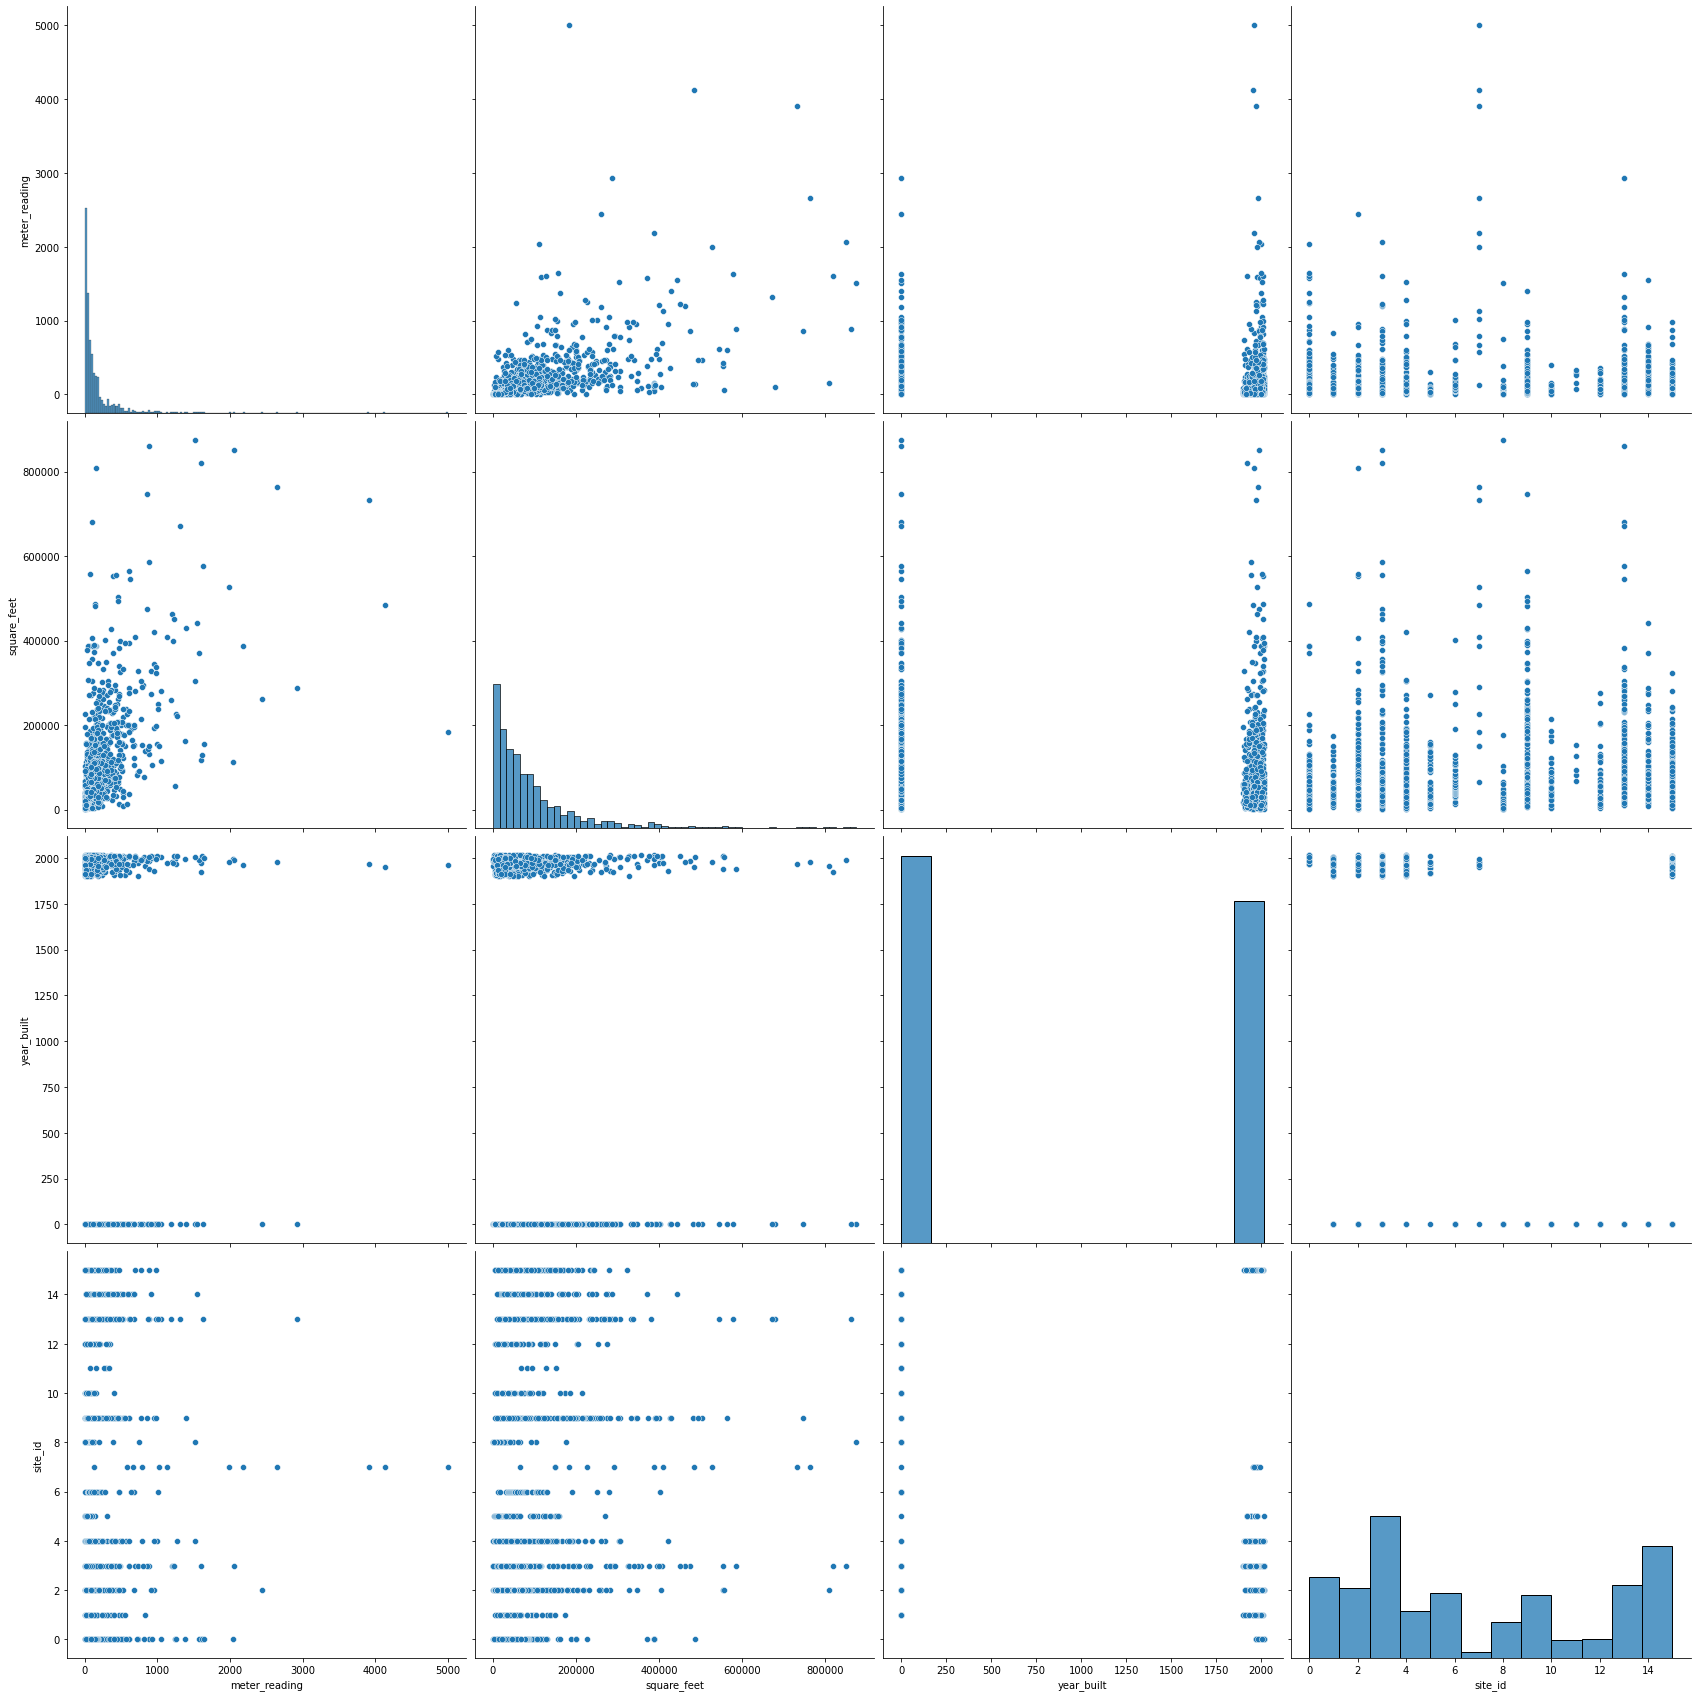

In [6]:
data_corr_meta = pd.DataFrame(energy.groupby("building_id").median(),
        columns=["meter_reading", "square_feet", "year_built", "site_id"])
data_corr_meta.dropna(inplace=True)
sns.pairplot(data_corr_meta, height=6)
plt.show()
del data_corr_meta

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


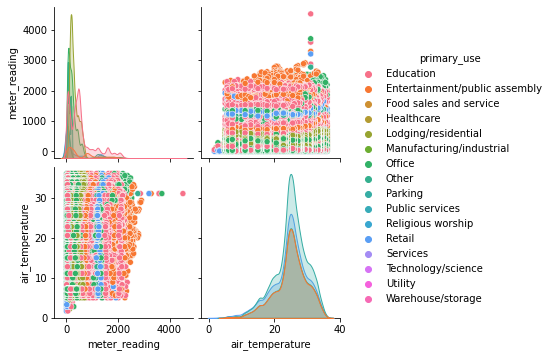

In [9]:
data_corr_temp_primary = pd.DataFrame(energy[energy['site_id'] == 0],columns=['meter_reading','air_temperature','primary_use',])
data_corr_temp_primary.dropna(inplace=True)
sns.pairplot(data_corr_temp_primary,hue='primary_use')

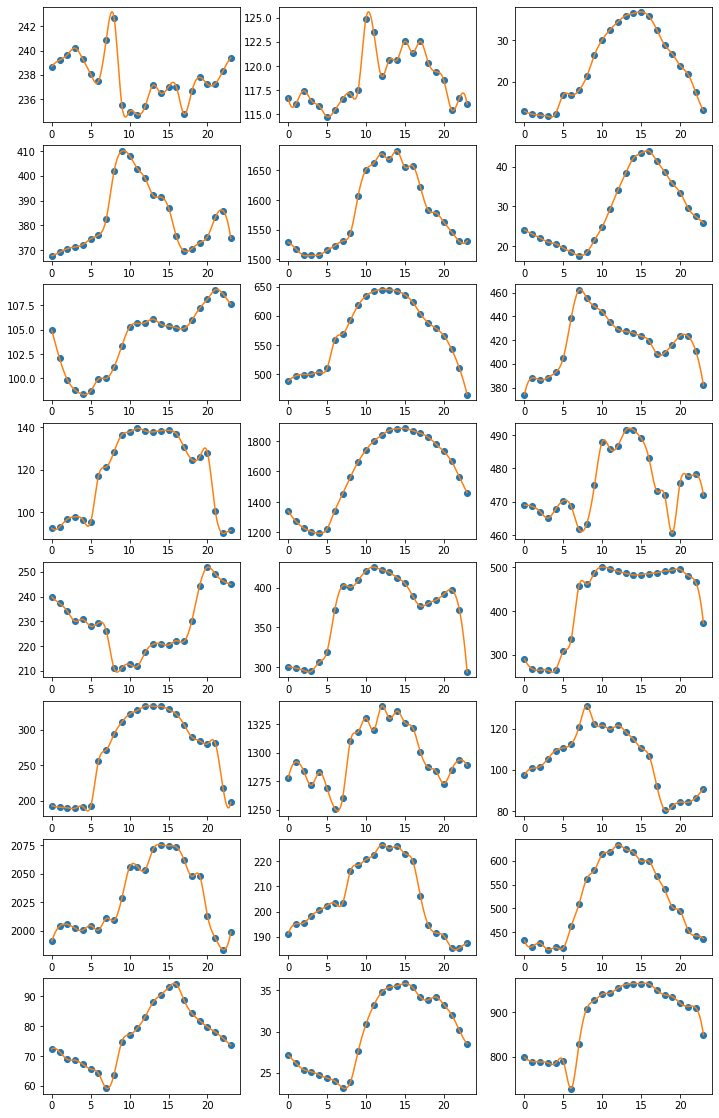

In [13]:
energy['hour'] = energy['timestamp'].dt.hour
fig = plt.figure(figsize=(12,20))
for i in range(0,24):
  fig.add_subplot(8,3,i+1)
  df_i = energy[(energy['building_id'] == i) & energy['meter_reading']]
  df_i_hourly = df_i.groupby('hour').mean().reset_index()
  x = np.arange(0,24)
  y = interp1d(x,df_i_hourly['meter_reading'],kind='cubic')
  xn = np.arange(0,23.1,0.1)
  yn = y(xn)
  plt.plot(x,df_i_hourly['meter_reading'],'o',xn,yn)

In [14]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [15]:
dates_range = pd.date_range(start='2015-12-31',end='2017-01-01')

us_holidays = calendar().holidays(start=dates_range.min(),end=dates_range.max())

In [17]:
energy['dayofweek'] = energy['timestamp'].dt.dayofweek.astype("int8")
energy['day'] = energy['timestamp'].dt.day.astype("int8")
energy['dayofyear'] = energy['timestamp'].dt.dayofyear.astype("int16")
energy['month'] = energy['timestamp'].dt.month.astype("int8")
energy['week'] = energy['timestamp'].dt.week.astype("int8")
energy['date'] = pd.to_datetime(energy['timestamp'].dt.date)
energy['is_holiday'] = (energy['date'].isin(us_holidays)).astype("int8")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


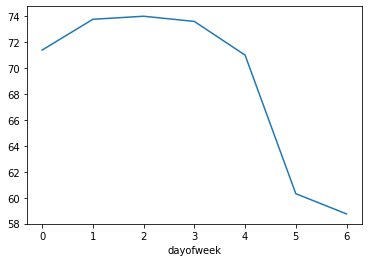

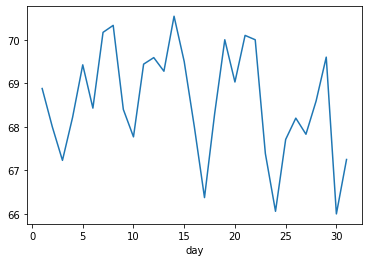

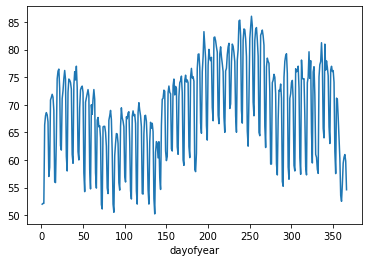

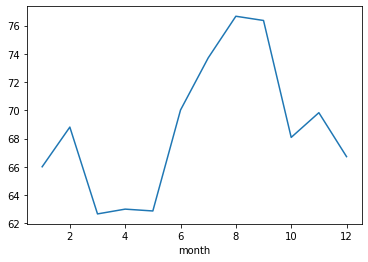

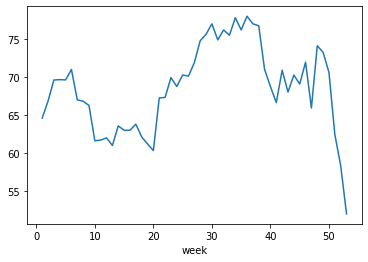

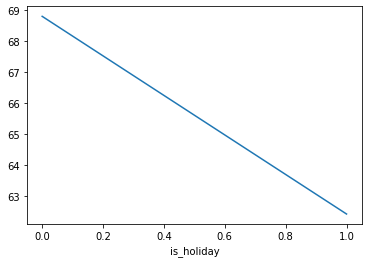

In [22]:
for col in ['dayofweek','day','dayofyear','month','week','is_holiday']:
  energy.groupby(col).median()['meter_reading'].plot() 
  plt.show()